# **Self-Attention and Positional Encoding in Transformers (From Scratch)**

This notebook is a step-by-step, hands-on implementation of **Self-Attention** and **Positional Encoding** — two fundamental building blocks of the Transformer architecture — using PyTorch.

- The **concept and intuition** behind self-attention.
- How to implement a **single attention head** from scratch.
- Why positional information is essential in sequence models.
- Different approaches to **positional encoding**:
  - Linear encoding
  - Sinusoidal encoding
  - Custom periodic functions
- How to visualize embeddings in 3D space to understand learned token relationships.
- Integrating self-attention with positional encodings in a PyTorch model.


# Self-attention
Self-attention is a mechanism used in neural networks to help the model focus on different parts of the input data when generating each part of the output. It is a key component of the Transformer architecture, which is widely used in natural language processing tasks such as machine translation, text summarization, and sentiment analysis.

The idea behind self-attention is to allow the model to weigh the importance of each input token when generating each output token. This is done by computing a weighted sum of the input tokens, where the weights are determined by the relationships between all pairs of input tokens.

In [4]:
# Install packages
# !pip install Levenshtein
# !pip install matplotlib
# !pip install torch==2.3.0 torchtext==0.18.0

### Importing required libraries


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from Levenshtein import distance
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import matplotlib.pyplot as plt

# suppress warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
split = 'train'

# Training parameters
learning_rate = 3e-4
batch_size = 64
max_iters = 5000
eval_interval = 200           # Evaluate model every 'eval_interval' iterations in the training loop
eval_iters = 100              # When evaluating, approximate loss using 'eval_iters' batches

# Architecture parameters
max_vocab_size = 256          # Maximum vocabulary size
vocab_size = max_vocab_size   # Real vocabulary size (e.g. BPE has a variable length, so it can be less than 'max_vocab_size')
block_size = 16               # Context length for predictions
n_embd = 32                   # Embedding size
num_heads = 2                 # Number of head in multi-headed attention
n_layer = 2                   # Number of Blocks
ff_scale_factor = 4           # Note: The '4' magic number is from the paper: equation 2 uses d_model=512, but d_ff=2048
dropout = 0.0                 # Normalization using dropout# 10.788929 M parameters

head_size = n_embd // num_heads
assert (num_heads * head_size) == n_embd

`plot_embeddings` function to visualize the learned embeddings in a 3D space using `matplotlib`. This helps in understanding how the embeddings cluster and separate different tokens, providing insight into what the model has learned.

In [21]:
def plot_embdings(my_embdings, name):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(my_embdings[:, 0], my_embdings[:, 1], my_embdings[:, 2])

    for j, label in enumerate(name):
        ax.text(my_embdings[j, 0], my_embdings[j, 1], my_embdings[j, 2], label)

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()

# Self-attention class
Creating a self-attention heads from scratch. 

The `Head` class represents a self-attention head. It extends PyTorch's `nn.Module`, making it a part of a neural network that can learn from data.

<p style="text-align:center">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/attention.png" width="200" alt="attention"/>
</p>


$$
Attention(Q, K, V)  => Attention(Q \cdot W^Q, K \cdot W^K, V \cdot W^V)
$$


    batch_size (B): The number of independent sequences we process at once. (e.g., B=4)
    block_size (T): The length of each sequence (number of tokens). (e.g., T=8)
    vocab_size (V): The number of unique tokens in our dictionary. (e.g., V=65)
    n_embd (C): The embedding dimension; the size of the vector for each token. (e.g., C=32)

    Variable	     Description      	                            Shape	      Example Shape
    x	             Input token indices	                        (B, T)        (4, 8)
    embedded_x	     Input token embeddings	                        (B, T, C) 	  (4, 8, 32)
    q, k, v	         Query, Key, and Value                          (B, T, C)	  (4, 8, 32)
    w               (raw) Attention scores (q @ k.T / sqrt(d_k))	(B, T, T)	  (4, 8, 8)
    w               (probabilities)	                                (B, T, T)	  (4, 8, 8)
    out	             Final output of the head	                    (B, T, C)	  (4, 8, 32)

In [5]:
class Head(nn.Module):
    """ Self attention head. This class implements a self-attention mechanism
        which is a key component of transformer-based neural network architectures.
    """

    def __init__(self):
        super().__init__()  # Initialize the superclass (nn.Module)
        # Embedding layer to convert input token indices to vectors of fixed size (n_embd)
        self.embedding = nn.Embedding(vocab_size, n_embd)
        # Linear layers to compute the queries, keys, and values from the embeddings
        # to perform a linear transformation (a matrix multiplication) 
        self.key = nn.Linear(n_embd, n_embd, bias=False)
        self.query = nn.Linear(n_embd, n_embd, bias=False)
        self.value = nn.Linear(n_embd, n_embd, bias=False)

    def attention(self, x):
        embedded_x = self.embedding(x)
        k = self.key(embedded_x)
        q = self.query(embedded_x)
        v = self.value(embedded_x)
        # Attention score
        w = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5   # Query * Keys / normalization
        w = F.softmax(w, dim=-1)  # Do a softmax across the last dimesion
        return embedded_x, k, q, v, w
    
    def forward(self, x):
        # Input Shape: (B, T)
        # Output Shape: (B, T, C)
        embedded_x = self.embedding(x)

        # Input Shape: (B, T, C) C = embd_dim
        # Output Shape (for k, q, and v): (B, T, C) 
        k = self.key(embedded_x)
        q = self.query(embedded_x)
        v = self.value(embedded_x)

        # Attention score  (B, C, T)
        # For each item in the batch, it multiplies a (T, C) matrix (q) by a (C, T) matrix (k.transpose).
        # Result shape: (B, T, T)
        # The value w[b, i, j] represents how much token i should attend to token j in batch b.
        # * k.shape[-1]**-0.5: This is the scaling factor 1/sqrt(d_k)
        w = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5   # Query * Keys / normalization
        w = F.softmax(w, dim=-1)  # Do a softmax across the last dimesion
        
        # Add weighted values
        # w Shape: (B, T, T)
        # v Shape: (B, T, C)
        # Output Shape: (B, T, C)
        out = w @ v
        return out     # The final output of the attention head has the exact same shape as the input embeddings.

### Dataset definition
Transformations on input text, a sample dataset is defined, a list of tuples, each containing an ID and a string of text related to various NLP tasks.

In [63]:
dataset = [
    (1, "Introduction to NLP"),
    (2, "Basics of PyTorch"),
    (1, "NLP Techniques for Text Classification"),
    (3, "Named Entity Recognition with PyTorch"),
    (3, "Sentiment Analysis using PyTorch"),
    (3, "Machine Translation with PyTorch"),
    (1, " NLP Named Entity,Sentiment Analysis,Machine Translation "),
    (1, " Machine Translation with NLP "),
    (1, " Named Entity vs Sentiment Analysis  NLP "),
    (3, "he painted the car red"),
    (1, "he painted the red car")
    ]

### Tokenization setup
A tokenizer is created using `torchtext`'s `get_tokenizer` function which will break down strings into tokens (words).

In [64]:
tokenizer = get_tokenizer("basic_english")

### Vocabulary building
The function `yield_tokens` iterates over the dataset and yields tokenized versions of the text data. These tokens are then used by `build_vocab_from_iterator` to create a vocabulary object, which includes a special `<unk>` token for unknown words.

In [65]:
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(dataset), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

### Text processing pipeline
A `text_pipeline` function is defined to convert raw text strings into token indices using the tokenizer and the vocabulary.


In [66]:
def text_pipeline(x):
    return vocab(tokenizer(x))

### Hyperparameter definition
Hyperparameters for the model are specified, including the size of the vocabulary and the embedding dimension.


In [67]:
vocab_size = len(vocab) 
n_embd = 3

# Creating the attention head with the integrated embedding layer
attention_head = Head()

### Dummy data for testing
Dummy input data is created for testing, and the `text_pipeline` function is applied to convert the input text into a tensor of token indices, which will be used as input to the neural network model.

In [68]:
my_tokens = 'he painted the car red'
input_data = torch.tensor(text_pipeline(my_tokens), dtype=torch.long)

print(input_data.shape)
print(input_data)

torch.Size([5])
tensor([12, 13, 15, 11, 14])


Pass the tokenized input data through the embedding layer and the attention mechanism of the Head class

In [69]:
embedded_x, k, q, v, w = attention_head.attention(input_data)

print(embedded_x.shape)  # [number of tokens, embedding dimension]
print("embedded_x:", embedded_x)

torch.Size([5, 3])
embedded_x: tensor([[-0.2160, -0.4254,  0.0829],
        [-0.2933, -0.1654,  0.6749],
        [-0.8349,  0.7680,  0.1133],
        [-0.1348, -2.4946, -1.6414],
        [ 1.2065,  0.0518,  1.2653]], grad_fn=<EmbeddingBackward0>)


    The shapes of the key, query, value, and attention weight matrices. This helps verify the dimensions are as expected for the attention calculations

In [70]:
print("k:", k.shape) 
print("q:", q.shape) 
print("v:", v.shape) 
print("w:", w.shape) 

k: torch.Size([5, 3])
q: torch.Size([5, 3])
v: torch.Size([5, 3])
w: torch.Size([5, 5])


    The value at w[i, j] is the raw score of how much attention token i should pay to token j.

In [71]:
# Now we actually pass the input data through the entire attention head to get the output
output = attention_head(input_data)

# Print the output and its shape, which should match the shape of the input
# The output tensor contains the final attention-applied representations of the input
print(output.shape)
print(output)

torch.Size([5, 3])
tensor([[-0.0179,  0.1718, -0.1541],
        [-0.0115,  0.0985, -0.0928],
        [-0.0192,  0.1059, -0.0905],
        [-0.1575,  0.5521, -0.3413],
        [-0.0191, -0.0187,  0.0276]], grad_fn=<MmBackward0>)


# Positional encoding

'He painted the car red' and 'He painted the red car.' These sentences have different meanings due to the different positions of the words 'red' and 'car.' Properly implemented positional encodings would allow the model to distinguish between the positions of these words, ensuring that the embeddings for these sentences are distinct.


In sequence processing tasks, it's crucial for the model to understand the positions of elements within a sequence. 


In [72]:
# Generate a range of position indices from 0 to the size of the vocabulary
position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)

# Retrieve the list of words from the vocabulary object
vocab_list = list(vocab.get_itos())

# Iterate over the range of vocabulary size
for idx in range(vocab_size):
    word = vocab_list[idx]  # Get the word from the vocabulary list at the current index
    pos = position[idx][0].item()  # Extract the numerical value of the position index from the tensor
    print(f"Word: {word}, Position Index: {pos}")

Word: <unk>, Position Index: 0.0
Word: nlp, Position Index: 1.0
Word: pytorch, Position Index: 2.0
Word: analysis, Position Index: 3.0
Word: entity, Position Index: 4.0
Word: machine, Position Index: 5.0
Word: named, Position Index: 6.0
Word: sentiment, Position Index: 7.0
Word: translation, Position Index: 8.0
Word: with, Position Index: 9.0
Word: ,, Position Index: 10.0
Word: car, Position Index: 11.0
Word: he, Position Index: 12.0
Word: painted, Position Index: 13.0
Word: red, Position Index: 14.0
Word: the, Position Index: 15.0
Word: basics, Position Index: 16.0
Word: classification, Position Index: 17.0
Word: for, Position Index: 18.0
Word: introduction, Position Index: 19.0
Word: of, Position Index: 20.0
Word: recognition, Position Index: 21.0
Word: techniques, Position Index: 22.0
Word: text, Position Index: 23.0
Word: to, Position Index: 24.0
Word: using, Position Index: 25.0
Word: vs, Position Index: 26.0


In positional encodings, each dimension \(d\) within the embedding holds specific importance, denoted as $\textbf{p}_{n,d}$. For example, if we have an embedding dimension of three, the positional encodings $\textbf{p}_{n,d}$ ​are represented as $[\text{ }p_{n,1},\text{ }p_{n,2},\text{ }p_{n,3}]$. These values correspond to a three-dimensional embedding for each token, capturing its position and unique characteristics within the sequence. By organizing positional information this way, the model gains a richer understanding of the relationship between tokens.


In [73]:
# Initialize a matrix of zeros with dimensions [vocab_size, n_embd]
# This will be used to hold the positional encodings for each word in the vocabulary
pe = torch.zeros(vocab_size, n_embd)

# Concatenate the position tensor three times along dimension 1 (columns)
# This simplistic example is likely a placeholder for a more complex function of position that would be used in a real positional encoding
pe = torch.cat((position, position, position), 1)

# Display the positional encoding tensor
# In an actual implementation, this would involve a more sophisticated method that reflects the position's impact on the embeddings
pe

tensor([[ 0.,  0.,  0.],
        [ 1.,  1.,  1.],
        [ 2.,  2.,  2.],
        [ 3.,  3.,  3.],
        [ 4.,  4.,  4.],
        [ 5.,  5.,  5.],
        [ 6.,  6.,  6.],
        [ 7.,  7.,  7.],
        [ 8.,  8.,  8.],
        [ 9.,  9.,  9.],
        [10., 10., 10.],
        [11., 11., 11.],
        [12., 12., 12.],
        [13., 13., 13.],
        [14., 14., 14.],
        [15., 15., 15.],
        [16., 16., 16.],
        [17., 17., 17.],
        [18., 18., 18.],
        [19., 19., 19.],
        [20., 20., 20.],
        [21., 21., 21.],
        [22., 22., 22.],
        [23., 23., 23.],
        [24., 24., 24.],
        [25., 25., 25.],
        [26., 26., 26.]])

we only need positional encodings for each sequence of embeddings, to determine this.


In [74]:
samples, dim = embedded_x.shape
samples, dim

(5, 3)

Add the positional encodings to the embeddings and plot the results


In [75]:
# Select the appropriate positional encodings based on the number of samples and embedding dimensions
# This slice of the positional encoding tensor 'pe' corresponds to the actual batch size and embedding size
pe_slice = pe[0:samples, 0:n_embd]

In [76]:
pe_slice

tensor([[0., 0., 0.],
        [1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.],
        [4., 4., 4.]])

In [77]:
# Add the positional encodings to the token embeddings
# This step integrates the position information into the embeddings
pos_embding = embedded_x + pe_slice

# The result 'pos_embding' now contains the token embeddings adjusted with positional information
# Display the adjusted embeddings tensor
pos_embding

tensor([[-0.2160, -0.4254,  0.0829],
        [ 0.7067,  0.8346,  1.6749],
        [ 1.1651,  2.7680,  2.1133],
        [ 2.8652,  0.5054,  1.3586],
        [ 5.2065,  4.0518,  5.2653]], grad_fn=<AddBackward0>)

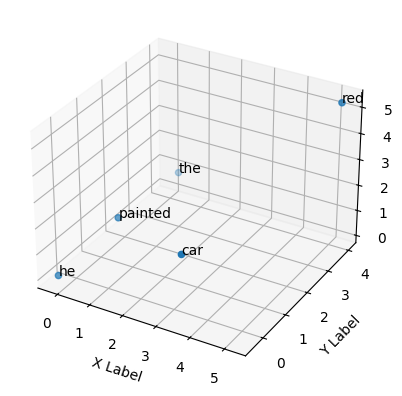

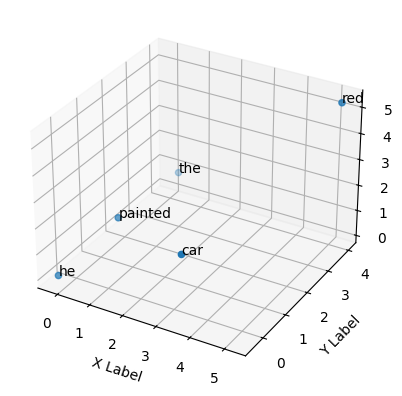

In [78]:
# Visualize the embeddings with positional encodings using the defined plot function
# 'pos_embding.detach().numpy()' converts the embeddings tensor to a NumPy array and detaches it from the current computation graph
# 'tokenizer(my_tokens)' tokenizes the sample sentence for labeling in the plot
# 'vocab' is passed to associate tokens with their embeddings for plotting
plot_embdings(pos_embding.detach().numpy(), tokenizer(my_tokens))
plot_embdings(pos_embding.detach().numpy(), tokenizer(my_tokens))

When incorporating linear positional encodings into embeddings, a significant challenge arises: the embeddings for positions later in the sequence tend to become much larger. This issue becomes especially prominent with longer sequences. To illustrate, let's consider the word 'car' appearing at indices 3 and 9 within a sequence. The embedding for 'car' at position 9 is noticeably larger than the one at position 3. This difference becomes more pronounced as the sequence length increases.

In [79]:
s = 'he painted the car red he painted the red car'
input_data = torch.tensor(text_pipeline(s), dtype=torch.long)
embedded_x, k, q, v, w = attention_head.attention(input_data)
output = attention_head(input_data)
samples, dim = embedded_x.shape
pe_slice = pe[0:samples, 0:n_embd]
pos_embding = embedded_x + pe_slice


indices = text_pipeline(s)
print('Word at pos = 3:', vocab.get_itos()[indices[3]], '\nPos_embd:', pos_embding[3])
print('Word at pos = 9:', vocab.get_itos()[indices[9]], '\nPos_embd:', pos_embding[9])

Word at pos = 3: car 
Pos_embd: tensor([2.8652, 0.5054, 1.3586], grad_fn=<SelectBackward0>)
Word at pos = 9: car 
Pos_embd: tensor([8.8652, 6.5054, 7.3586], grad_fn=<SelectBackward0>)


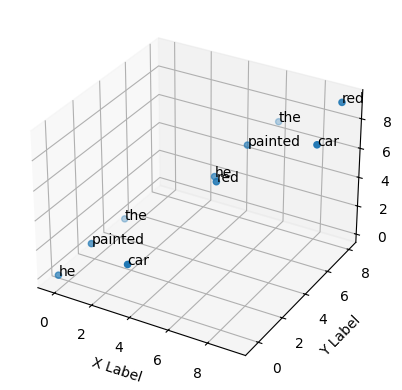

In [80]:
plot_embdings(pos_embding.detach().numpy(), tokenizer(s))

Address this magnitude issue through various approaches. First, employ a function that doesn't exhibit such significant amplification. Additionally, have the option to introduce different functions. For instance, when considering our word positional encodings, the magnitude of the positional encodings $\textbf{p}_{n,d}$ can be represented as $[p_{n,1}, p_{n,2}, p_{n,3}]$, which, in this case, translates to $[0.1n, -0.1n, 0]$.

In this modified scheme, the magnitudes of the first two dimensions $[p_{n,1}, p_{n,2}]$ increase linearly with the position $n$ but at a slower rate (0.1 times the position). The third dimension $[p_{n,3}]$ remains constant at 0. Adjusting these coefficients, can control the rate at which the magnitudes change, ensuring that the embeddings do not escalate significantly and providing a more balanced representation of positions within the sequence.


In [81]:
pe = torch.cat((0.1*position, -0.1*position, 0*position), 1)
pe

tensor([[ 0.0000, -0.0000,  0.0000],
        [ 0.1000, -0.1000,  0.0000],
        [ 0.2000, -0.2000,  0.0000],
        [ 0.3000, -0.3000,  0.0000],
        [ 0.4000, -0.4000,  0.0000],
        [ 0.5000, -0.5000,  0.0000],
        [ 0.6000, -0.6000,  0.0000],
        [ 0.7000, -0.7000,  0.0000],
        [ 0.8000, -0.8000,  0.0000],
        [ 0.9000, -0.9000,  0.0000],
        [ 1.0000, -1.0000,  0.0000],
        [ 1.1000, -1.1000,  0.0000],
        [ 1.2000, -1.2000,  0.0000],
        [ 1.3000, -1.3000,  0.0000],
        [ 1.4000, -1.4000,  0.0000],
        [ 1.5000, -1.5000,  0.0000],
        [ 1.6000, -1.6000,  0.0000],
        [ 1.7000, -1.7000,  0.0000],
        [ 1.8000, -1.8000,  0.0000],
        [ 1.9000, -1.9000,  0.0000],
        [ 2.0000, -2.0000,  0.0000],
        [ 2.1000, -2.1000,  0.0000],
        [ 2.2000, -2.2000,  0.0000],
        [ 2.3000, -2.3000,  0.0000],
        [ 2.4000, -2.4000,  0.0000],
        [ 2.5000, -2.5000,  0.0000],
        [ 2.6000, -2.6000,  0.0000]])

Plot the positional encodings.


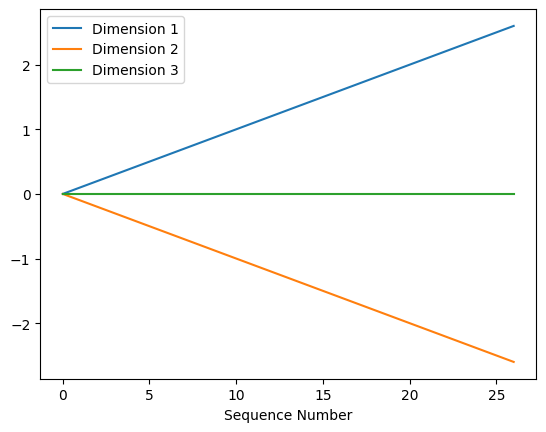

In [82]:
plt.plot(pe[:, 0].numpy(), label="Dimension 1")
plt.plot(pe[:, 1].numpy(), label="Dimension 2")
plt.plot(pe[:, 2].numpy(), label="Dimension 3")

# Label the x-axis as 'Sequence Number' to represent the position in the sequence
plt.xlabel("Sequence Number")
plt.legend()
plt.show()


Observe that the words are closer together, but employing a linear function still presents the same drawbacks. This means that eventually, the embeddings will keep on increasing linearly.


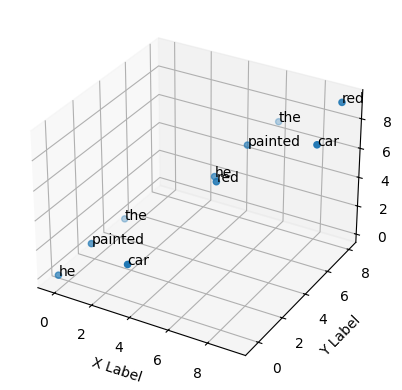

In [83]:
pos_embding_numpy = pos_embding.detach().numpy()
tokens = tokenizer(s)
plot_embdings(pos_embding_numpy, tokens)

When analyze positional encodings, it might appear that the words are closer together, indicating an improvement. However, it's crucial to recognize that the use of a linear function still comes with its own set of limitations. Despite the visual impression of words being in closer proximity, linear positional encodings have inherent issues. One significant problem is the potential for amplifying magnitudes as positions progress, which can adversely affect the model's ability to capture subtle positional nuances effectively.

To overcome these challenges, leveraging periodic functions, such as sine and cosine functions. These functions possess a unique property called periodicity, meaning they repeat their values over regular intervals. This periodic nature prevents them from growing too rapidly as positions increase in the sequence.

## leveraging periodic functions, such as sine and cosine functions

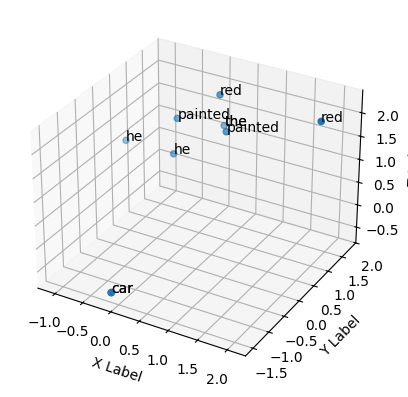

In [84]:
# Generate positional encodings using a sinusoidal function and concatenation
# The first dimension is encoded with a sine function
# The second and third dimensions are placeholders and are simply set to 1 (this is not typical in practice and likely serves as a simplified example)
pe = torch.cat((torch.sin(2 * 3.14 * position / 6),   # Sinusoidal encoding for dimension 1
                0 * position + 1,                     # Constant encoding (1) for dimension 2
                0 * position + 1), axis=1)            # Constant encoding (1) for dimension 3

# Add the sinusoidal positional encodings to the token embeddings
# This step enriches the embeddings with information about the position of each token in the sequence
pos_embding = embedded_x + pe[0:samples, :]
pos_embding_numpy = pos_embding.detach().numpy()
tokens = tokenizer(s)
plot_embdings(pos_embding_numpy, tokens)

In [85]:
len(pe)

27

noticed a fascinating pattern: words are generally positioned close enough in the embedding space to preserve their proximity, ensuring that they are contextually related while maintaining distinctiveness from one another. However, there's a significant exception that arises specifically with the word 'car.'

This peculiar behavior can be attributed to the nature of the sine wave used in positional encoding. The sine wave is inherently periodic, meaning it repeats its pattern at regular intervals.


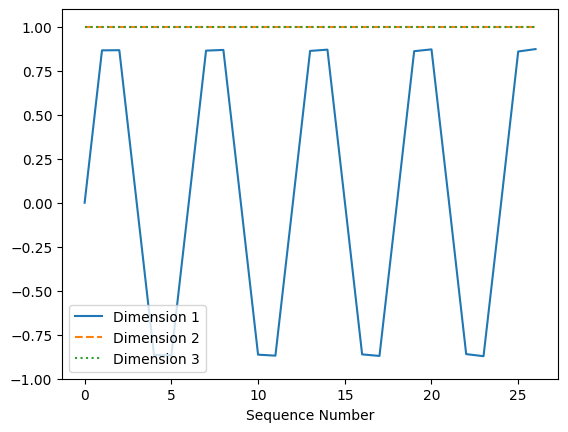

In [86]:
# Plot the positional encodings with different line styles and markers
plt.plot(pe[:, 0].numpy(), label="Dimension 1", linestyle='-')
plt.plot(pe[:, 1].numpy(), label="Dimension 2", linestyle='--')
plt.plot(pe[:, 2].numpy(), label="Dimension 3", linestyle=':')

plt.ylim([-1, 1.1])

plt.xlabel("Sequence Number")
plt.legend()
plt.show()

By incorporating sine and cosine functions with varying frequencies, encode sequences of differing lengths.

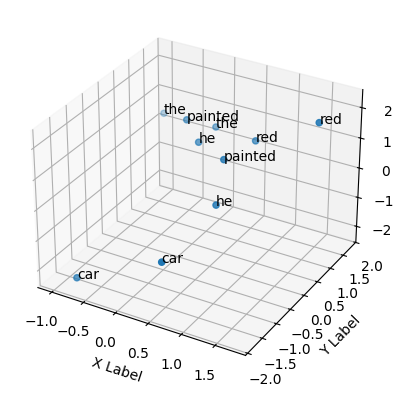

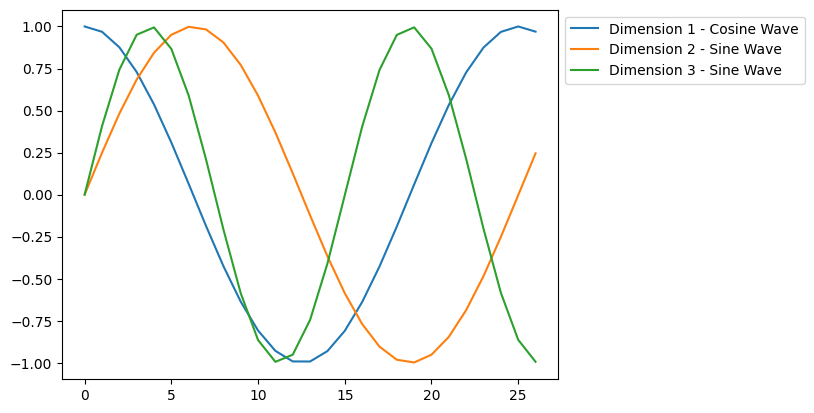

In [89]:
pe = torch.cat((torch.cos(2 * 3.14 * position / 25),  # Cosine function for the first dimension
                torch.sin(2 * 3.14 * position / 25),  # Sine function for the second dimension
                torch.sin(2 * 3.14 * position / 15)), axis=1)

pos_embding = embedded_x + pe[0:samples, :]
pos_embding_numpy = pos_embding.detach().numpy()
tokens = tokenizer(s)
plot_embdings(pos_embding_numpy, tokens)

plt.plot(pe[:, 0].numpy(), label="Dimension 1 - Cosine Wave")
plt.plot(pe[:, 1].numpy(), label="Dimension 2 - Sine Wave")
plt.plot(pe[:, 2].numpy(), label="Dimension 3 - Sine Wave")

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

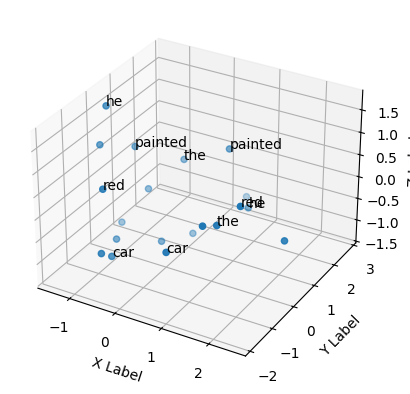

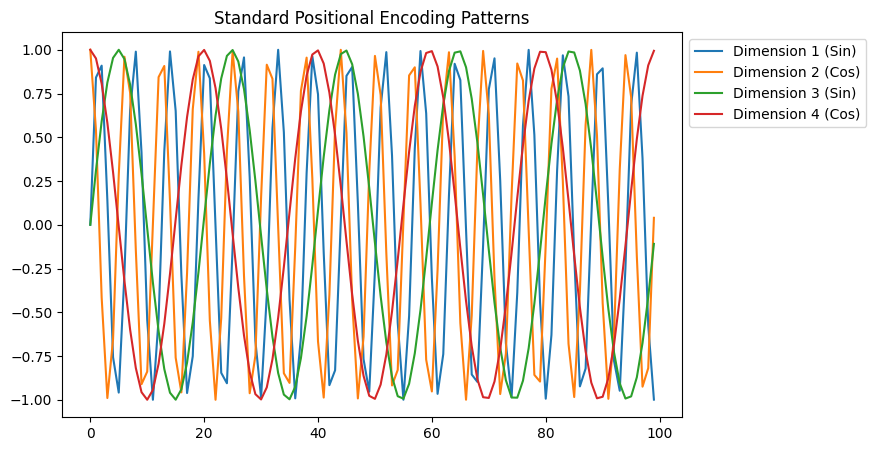

In [102]:
import math

# Parameters
max_len = 100   # Max sequence length
n_embd = 16     # Embedding dimension
samples = 20    # Number of tokens in current sequence

# 1. Standard positional encoding computation
pe = torch.zeros(max_len, n_embd)
position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
div_term = torch.exp(torch.arange(0, n_embd, 2).float() * (-math.log(10000.0) / n_embd))

# Apply sin to even dimensions; cos to odd dimensions
pe[:, 0::2] = torch.sin(position * div_term)
pe[:, 1::2] = torch.cos(position * div_term)

pos_embedding = embedded_x + pe[0:samples, :]

pos_embedding_numpy = pos_embedding.detach().numpy()
tokens = [f"{i}" for i in tokenizer(s)]

plot_embdings(pos_embedding_numpy, tokens)

# 4. Plot positional encoding patterns for first few dimensions
plt.figure(figsize=(8, 5))
plt.plot(pe[:, 0].numpy(), label="Dimension 1 (Sin)")
plt.plot(pe[:, 1].numpy(), label="Dimension 2 (Cos)")
plt.plot(pe[:, 2].numpy(), label="Dimension 3 (Sin)")
plt.plot(pe[:, 3].numpy(), label="Dimension 4 (Cos)")

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Standard Positional Encoding Patterns")
plt.show()

Overall, periodic functions provide a more expressive and adaptable means of encoding positional information in sequences, making them a preferred choice in modern sequence-to-sequence models like transformers. They offer improved capabilities for modeling both short-range and long-range dependencies, which are crucial for tasks in natural language processing and other domains.

In [111]:
class PositionalEncoding(nn.Module):
    """Standard sinusoidal positional encoding for Transformer models."""
    def __init__(self, n_embd, vocab_size, dropout=0.1):
        super(PositionalEncoding, self).__init__()

        # Create matrix of shape (max_len, n_embd)
        pe = torch.zeros(vocab_size, n_embd)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)  # (max_len, 1)

        # Divisor term: 10000^(2i/n_embd)
        div_term = torch.exp(torch.arange(0, n_embd, 2).float() * (-math.log(10000.0) / n_embd))

        # Apply sin to even indices in the array; cos to odd indices
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add a batch dimension at dim=0 -> shape (1, max_len, n_embd)
        # pe = pe.unsqueeze(0)

        # Save as non-trainable buffer
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add positional encoding to each embedding vector assuming x is (seq_len, batch_size, n_embd)
        # Note: 'pe' is a registered buffer and does not require gradients
        pos = x + self.pe[:x.size(0), :]
        return pos

In [112]:
# class PositionalEncoding(nn.Module):
#     """Positional encoding module injects some information about the relative or absolute position of the tokens in the sequence."""
#     def __init__(self, n_embd, vocab_size, dropout=0.1):
#         super(PositionalEncoding, self).__init__()
#         # Initialize a buffer for the positional encodings (not a parameter, so it's not updated during training)
#         pe = torch.zeros(vocab_size, n_embd)
#         position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
#         # Calculate the positional encodings once in log space
#         pe = torch.cat((torch.cos(2 * 3.14 * position / 25), torch.sin(2 * 3.14 * position / 25), torch.sin(2 * 3.14 * position / 15)), 1)
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         # Add positional encoding to each embedding vector assuming x is (seq_len, batch_size, n_embd)
#         # Note: 'pe' is a registered buffer and does not require gradients
#         pos = x + self.pe[:x.size(0), :]
#         return pos

class Head(nn.Module):
    """Self attention head."""
    def __init__(self, n_embd, vocab_size):
        super().__init__()
        # An embedding layer that converts input data (token indices) into dense vectors of fixed size
        self.embedding = nn.Embedding(vocab_size, n_embd)
        # The positional encoding layer
        self.pos_encoder = PositionalEncoding(n_embd, vocab_size)
        # Layers to transform the position-encoded embeddings into queries, keys, and values
        self.key = nn.Linear(n_embd, n_embd, bias=False)
        self.query = nn.Linear(n_embd, n_embd, bias=False)
        self.value = nn.Linear(n_embd, n_embd, bias=False)

    def forward(self, x):
        # Pass the input through the embedding layer to get fixed size dense embeddings
        embedded_x = self.embedding(x)
        # Pass the embeddings through the positional encoder
        p_encoded_x = self.pos_encoder(embedded_x)
        # Generate queries, keys, and values for the attention
        k = self.key(p_encoded_x)
        q = self.query(p_encoded_x)
        v = self.value(p_encoded_x)
        # Calculate the attention scores as the dot product of queries and keys
        w = q @ k.transpose(-2, -1) * k.shape[-1] ** -0.5  # Query * Keys / normalization
        # Apply the softmax function to the attention scores to get probabilities
        w = F.softmax(w, dim=-1)
        # Multiply the attention weights with the values to get the output
        out = w @ v
        return out

In the code above, the `Head` class is an implementation of a self-attention mechanism. It first converts each input token into a dense vector using an embedding layer, and then adds positional information to the vectors using a positional encoding layer. This is done to give the model some information about the position of each token in the input sequence.

Next, the `Head` class creates three different linear projections (key, query, and value) of the positionally-encoded input data using the `nn.Linear` layers defined in the `__init__` method. These projections are created by multiplying the input data with three different weight matrices.

The attention scores (also known as attention weights) are then computed by taking the dot product of the query and key projections, and then scaling the result by the square root of the key dimension. This is done to stabilize the gradients during training. The softmax function is then applied to these scores to ensure they sum up to 1.

Finally, the output of the attention head is computed by taking a weighted sum of the value projection, where the weights are the attention scores. This output is a weighted sum of the input data, where the weights are determined by the relationships between all pairs of input data points.

In [115]:
input_data.shape

torch.Size([10])

In [116]:
input_data

tensor([12, 13, 15, 11, 14, 12, 13, 15, 14, 11])

In [113]:
# Instantiate the Head class with embedding dimension and vocabulary size as parameters
transformer = Head(n_embd, vocab_size)

# Pass the input data through the transformer model to obtain the output
# This process includes embedding the input, adding positional encodings, and applying self-attention
out = transformer(input_data)

# Print the shape of the output tensor
# The shape will provide insight into how the data has been transformed through the model
print("Output shape:", out.shape)

# Display the output tensor itself
# This output represents the transformed data after applying the embedding, positional encoding, and self-attention mechanisms
print("Output:", out)

Output shape: torch.Size([10, 16])
Output: tensor([[ 4.4362e-01, -1.1797e-01,  8.1532e-01, -4.5679e-01,  6.5815e-02,
          2.6079e-01, -3.1354e-02, -1.1327e-02,  4.7593e-01,  2.0298e-01,
          6.4663e-03, -5.9317e-01,  6.0961e-01,  2.6766e-01,  3.5272e-01,
          1.0980e-01],
        [ 4.0233e-01, -2.0379e-01,  7.3987e-01, -3.8922e-01, -5.6561e-02,
          3.0935e-01, -3.7942e-02,  2.2270e-01,  4.3692e-01,  3.2401e-03,
          8.9723e-02, -6.1073e-01,  5.6727e-01,  2.3806e-01,  2.6090e-01,
          8.4239e-02],
        [ 2.2703e-01, -1.0976e-01,  1.0222e+00, -5.2585e-01,  3.2870e-02,
          4.2647e-01,  1.5498e-01, -1.3317e-01,  5.6225e-01,  3.5101e-01,
         -3.4123e-01, -7.0521e-01,  4.7229e-01,  3.4634e-01,  4.1388e-01,
          3.2026e-01],
        [ 4.6199e-01, -1.2577e-01,  8.1042e-01, -4.6280e-01,  6.4422e-02,
          2.4407e-01, -4.5614e-02, -6.5332e-03,  4.7902e-01,  2.0125e-01,
          2.4820e-02, -5.9686e-01,  6.2033e-01,  2.5448e-01,  3.4562e-01,


# Transformers in PyTorch

In [128]:
transformer_model = nn.Transformer(nhead=16, num_encoder_layers=12)

These two lines create random tensors to represent the source and target sequences for the Transformer model.

`src` represents 10 source sequences, each with a length of 32 and a feature dimension of 512.  
`tgt` represents 20 target sequences, each with a length of 32 and a feature dimension of 512.


In [129]:
src = torch.rand((10, 32, 512))
tgt = torch.rand((20, 32, 512))

In [130]:
out = transformer_model(src, tgt)

In [131]:
out.shape

torch.Size([20, 32, 512])

## MultiHead attention

The multi-head attention mechanism works by first splitting the `query`, `key`, and `value` inputs into multiple "heads," each with its own set of learnable weights. This process allows the model to learn different attention patterns in parallel. 

The outputs from all heads are concatenated and passed through a linear layer, known as the output projection, to combine the information learned by each head. This final output represents the contextually enriched sequence that can be used in subsequent layers of the Transformer model.


In [132]:
# Embedding dimension
embed_dim = 4
# Number of attention heads
num_heads = 2
print("should be zero:", embed_dim % num_heads)
# Initialize MultiheadAttention
multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=False)

should be zero: 0


In [133]:
seq_length = 10 
batch_size = 5 
query = torch.rand((seq_length, batch_size, embed_dim))
key = torch.rand((seq_length, batch_size, embed_dim))
value = torch.rand((seq_length, batch_size, embed_dim))
# Perform multi-head attention
attn_output, _= multihead_attn(query, key, value)
print("Attention Output Shape:", attn_output.shape)

Attention Output Shape: torch.Size([10, 5, 4])


## TransformerEncoderLayer and TransformerEncoder

The `TransformerEncoderLayer` and `TransformerEncoder` are essential components of the Transformer architecture in PyTorch. These components work together to create a multi-layer, attention-based neural network.

### TransformerEncoderLayer:
This is a single encoding layer in the Transformer architecture, consisting of two primary sub-layers: the Multi-head Self-Attention layer and the Feed-Forward Network (FFN). Each of these sub-layers is followed by a residual connection and layer normalization.

### TransformerEncoder:
The TransformerEncoder is a stack of multiple `TransformerEncoderLayer` instances. The encoder consists of N identical layers. N can be adjusted based on the desired complexity of the model.

The encoder takes an input sequence, applies positional encoding, and passes it through each of the TransformerEncoderLayers sequentially. This allows the model to learn rich, hierarchical representations of the input sequence, capturing both local and long-range dependencies.

In [136]:
embed_dim = 4
num_heads = 2
print("should be zero", embed_dim % num_heads)
num_layers = 6
encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)

# Build the transformer encoder by stacking the encoder layer 6 times.
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

should be zero 0


Let's now test it with a random input:


In [137]:
seq_length = 10 
batch_size = 5 
x = torch.rand((seq_length, batch_size, embed_dim))
encoded = transformer_encoder(x)
print("Encoded Tensor Shape:", encoded.shape)

Encoded Tensor Shape: torch.Size([10, 5, 4])


In [138]:
embed_dim = 240
num_heads = 12
num_layers = 12
encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

seq_length = 20
batch_size = 1
x = torch.rand((seq_length, batch_size, embed_dim))
encoded = transformer_encoder(x)
print("Encoded Tensor Shape:", encoded.shape)

Encoded Tensor Shape: torch.Size([20, 1, 240])
